In [1]:
# ----------------------------------------------------------
# Cell 1: Load saved layer activations and metadata
# ----------------------------------------------------------
import numpy as np
import pandas as pd
from pathlib import Path

# Project root (adjust automatically)
project_root = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().resolve().parent
results_dir = project_root / "results" / "activations"

# File paths
layer1_path = results_dir / "adult_dnn_layer1.npy"
layer2_path = results_dir / "adult_dnn_layer2.npy"
meta_path   = results_dir / "adult_dnn_metadata.csv"

# Load data
layer1_act = np.load(layer1_path)
layer2_act = np.load(layer2_path)
meta = pd.read_csv(meta_path)

# Quick checks
print("✅ Files loaded successfully!")
print(f"Layer 1 activations shape: {layer1_act.shape}")
print(f"Layer 2 activations shape: {layer2_act.shape}")
print(f"Metadata shape: {meta.shape}")
print("\nMetadata columns:", list(meta.columns)[:8])
print(meta.head(3))


✅ Files loaded successfully!
Layer 1 activations shape: (11306, 64)
Layer 2 activations shape: (11306, 32)
Metadata shape: (11306, 5)

Metadata columns: ['sex', 'race', 'y_true', 'y_prob', 'y_pred']
      sex   race  y_true    y_prob  y_pred
0    Male  White       0  0.097896       0
1  Female  White       0  0.012861       0
2    Male  White       0  0.182906       0


In [2]:
# ----------------------------------------------------------
# ICA on layer-2 + correlations with sex/race/label
# ----------------------------------------------------------
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.decomposition import FastICA
from scipy import stats

# Paths
project_root = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().resolve().parent
iva_dir = project_root / "results" / "iva"
iva_dir.mkdir(parents=True, exist_ok=True)

# X = layer 2 activations (samples x units)
X = layer2_act.astype(np.float64, copy=False)

# Encode sensitive attributes
sex_codes = meta["sex"].astype("category").cat.codes.to_numpy()     # e.g., Female=0, Male=1
race_codes = meta["race"].astype("category").cat.codes.to_numpy()   # ordinal codes across race groups
y_true = meta["y_true"].to_numpy()

# Fit ICA (proxy for IVA when we only have one layer/source)
n_comp = min(20, X.shape[1])  # up to 20 or num_units if smaller
ica = FastICA(n_components=n_comp, random_state=42, whiten="unit-variance", max_iter=2000)
S = ica.fit_transform(X)  # (n_samples x n_comp) independent components

# Helper: Spearman correlations for each component vs a target vector
def spearman_vs(vec, name):
    corrs = [
        stats.spearmanr(S[:, j], vec, nan_policy="omit").correlation
        for j in range(S.shape[1])
    ]
    out = pd.DataFrame({"component": range(S.shape[1]), f"spearman_with_{name}": corrs})
    out["abs_corr"] = out[f"spearman_with_{name}"].abs()
    return out.sort_values("abs_corr", ascending=False).reset_index(drop=True)

# Correlation tables
corr_sex   = spearman_vs(sex_codes,  "sex")
corr_race  = spearman_vs(race_codes, "race")
corr_label = spearman_vs(y_true,     "label")

# Persist results
corr_sex.to_csv(iva_dir / "ica_corr_sex.csv", index=False)
corr_race.to_csv(iva_dir / "ica_corr_race.csv", index=False)
corr_label.to_csv(iva_dir / "ica_corr_label.csv", index=False)

# Quick summary to screen
print("Top components linked to SEX:")
print(corr_sex.head(10).to_string(index=False))

print("\nTop components linked to RACE:")
print(corr_race.head(10).to_string(index=False))

print("\nTop components linked to LABEL (task signal):")
print(corr_label.head(10).to_string(index=False))

# Save a brief text summary
summary = []
summary.append("=== ICA on layer-2 activations ===")
summary.append(f"Samples: {X.shape[0]}  |  Units: {X.shape[1]}  |  Components: {n_comp}")
summary.append("\nTop 5 components by sex correlation:\n"  + corr_sex.head(5).to_string(index=False))
summary.append("\nTop 5 components by race correlation:\n" + corr_race.head(5).to_string(index=False))
summary.append("\nTop 5 components by label correlation:\n"+ corr_label.head(5).to_string(index=False))

(iva_dir / "ica_summary.txt").write_text("\n".join(summary), encoding="utf-8")
print(f"\nSaved CSVs and summary to: {iva_dir}")


Top components linked to SEX:
 component  spearman_with_sex  abs_corr
        19          -0.388271  0.388271
        11          -0.386399  0.386399
         6           0.274638  0.274638
        17           0.251977  0.251977
         9           0.214162  0.214162
        12          -0.206920  0.206920
        18          -0.160132  0.160132
         7          -0.143396  0.143396
        15           0.133181  0.133181
         2           0.103043  0.103043

Top components linked to RACE:
 component  spearman_with_race  abs_corr
         0            0.216890  0.216890
         5            0.203695  0.203695
        12           -0.176535  0.176535
         1           -0.159142  0.159142
         2            0.134605  0.134605
         8           -0.118691  0.118691
         7           -0.117634  0.117634
         3           -0.095807  0.095807
         6            0.093305  0.093305
        10            0.084933  0.084933

Top components linked to LABEL (task signal):


In [4]:
# ----------------------------------------------------------
# ICA on layer-2 activations + correlation analysis
# ----------------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
from scipy import stats
from pathlib import Path

# Define paths
project_root = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().resolve().parent
act_dir = project_root / "results" / "activations"
iva_dir = project_root / "results" / "iva"
iva_dir.mkdir(parents=True, exist_ok=True)

# Load data
layer2_path = act_dir / "adult_dnn_layer2.npy"
meta_path = act_dir / "adult_dnn_metadata.csv"

layer2_act = np.load(layer2_path)
meta = pd.read_csv(meta_path)

print(f"Layer2 activations: {layer2_act.shape}, Metadata: {meta.shape}")
print("Metadata columns:", meta.columns.tolist())

# --------------------------------------------------------------------
# Run ICA on Layer 2 activations
# --------------------------------------------------------------------
ica = FastICA(n_components=layer2_act.shape[1], random_state=42)
S = ica.fit_transform(layer2_act)

# --------------------------------------------------------------------
# Correlations with sensitive and label attributes
# --------------------------------------------------------------------
def spearman_corr(x, y):
    """Compute Spearman correlation safely."""
    corr = stats.spearmanr(x, y, nan_policy="omit").correlation
    return 0 if np.isnan(corr) else corr

# Encode categorical metadata
sex_codes = meta["sex"].astype("category").cat.codes
race_codes = meta["race"].astype("category").cat.codes
label_codes = meta["y_true"]

# Compute correlations
corrs_sex = [spearman_corr(S[:, i], sex_codes) for i in range(S.shape[1])]
corrs_race = [spearman_corr(S[:, i], race_codes) for i in range(S.shape[1])]
corrs_label = [spearman_corr(S[:, i], label_codes) for i in range(S.shape[1])]

# Create DataFrames
df_sex = pd.DataFrame({"component": range(S.shape[1]), "spearman_with_sex": corrs_sex})
df_race = pd.DataFrame({"component": range(S.shape[1]), "spearman_with_race": corrs_race})
df_label = pd.DataFrame({"component": range(S.shape[1]), "spearman_with_label": corrs_label})

for df in [df_sex, df_race, df_label]:
    df["abs_corr"] = df.iloc[:, 1].abs()

# Sort and show top correlated components
print("\nTop components linked to SEX:")
print(df_sex.sort_values("abs_corr", ascending=False).head(10))

print("\nTop components linked to RACE:")
print(df_race.sort_values("abs_corr", ascending=False).head(10))

print("\nTop components linked to LABEL (task signal):")
print(df_label.sort_values("abs_corr", ascending=False).head(10))

# Save results
df_sex.to_csv(iva_dir / "ica_corr_sex.csv", index=False)
df_race.to_csv(iva_dir / "ica_corr_race.csv", index=False)
df_label.to_csv(iva_dir / "ica_corr_label.csv", index=False)

print(f"\nSaved CSVs and summary to: {iva_dir}")


Layer2 activations: (11306, 32), Metadata: (11306, 5)
Metadata columns: ['sex', 'race', 'y_true', 'y_prob', 'y_pred']

Top components linked to SEX:
    component  spearman_with_sex  abs_corr
22         22           0.391288  0.391288
25         25           0.298039  0.298039
23         23           0.290152  0.290152
28         28          -0.232624  0.232624
21         21           0.203838  0.203838
29         29          -0.202085  0.202085
5           5           0.183781  0.183781
24         24           0.165394  0.165394
7           7           0.147420  0.147420
10         10          -0.127675  0.127675

Top components linked to RACE:
    component  spearman_with_race  abs_corr
6           6            0.183627  0.183627
11         11           -0.178820  0.178820
20         20            0.176429  0.176429
7           7            0.169192  0.169192
30         30            0.163609  0.163609
1           1           -0.156381  0.156381
21         21            0.128301  0.1

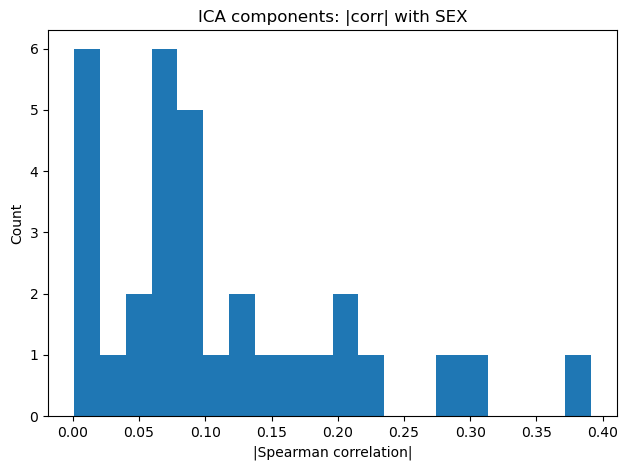

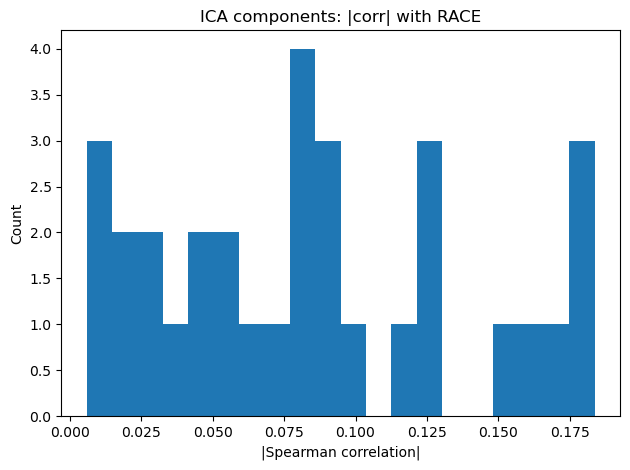

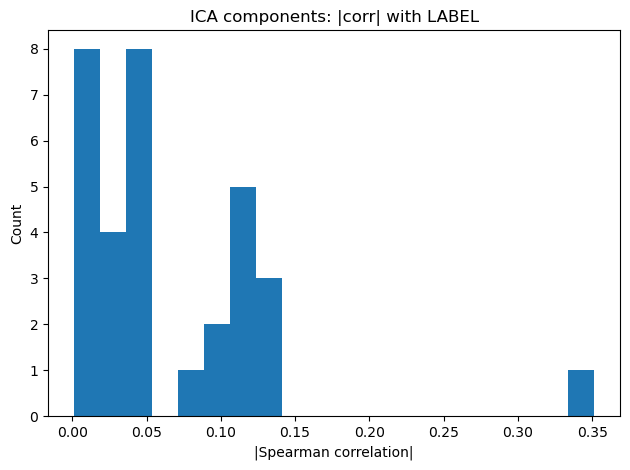


Candidate ICs for debiasing (high sensitive corr, low label corr):
    component   rho_sex  abs_rho_sex  rho_race  abs_rho_race  rho_label  \
25         25  0.298039     0.298039  0.027111      0.027111  -0.040869   
23         23  0.290152     0.290152 -0.039286      0.039286   0.015759   

    abs_rho_label  max_sensitive_abs  
25       0.040869           0.298039  
23       0.015759           0.290152  

Saved plots and candidates in: C:\Users\hana1\Documents\iva-bias-project\results\iva


In [5]:
# ----------------------------------------------------------
# Cell 3: Visualize ICA correlations + pick candidate ICs
# ----------------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

project_root = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().resolve().parent
iva_dir = project_root / "results" / "iva"
iva_dir.mkdir(parents=True, exist_ok=True)

# Load the CSVs saved in Cell 2
corr_sex   = pd.read_csv(iva_dir / "ica_corr_sex.csv")
corr_race  = pd.read_csv(iva_dir / "ica_corr_race.csv")
corr_label = pd.read_csv(iva_dir / "ica_corr_label.csv")

# 1) Histograms of correlation strengths (absolute Spearman)
plt.figure()
plt.hist(corr_sex["abs_corr"], bins=20)
plt.title("ICA components: |corr| with SEX")
plt.xlabel("|Spearman correlation|")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(iva_dir / "ica_abs_corr_sex_hist.png", dpi=160)
plt.show()

plt.figure()
plt.hist(corr_race["abs_corr"], bins=20)
plt.title("ICA components: |corr| with RACE")
plt.xlabel("|Spearman correlation|")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(iva_dir / "ica_abs_corr_race_hist.png", dpi=160)
plt.show()

plt.figure()
plt.hist(corr_label["abs_corr"], bins=20)
plt.title("ICA components: |corr| with LABEL")
plt.xlabel("|Spearman correlation|")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(iva_dir / "ica_abs_corr_label_hist.png", dpi=160)
plt.show()

# 3) Candidate ICs for debiasing:
#    High |corr| with sex or race, but low |corr| with label.
HIGH = 0.25   # threshold for "high" sensitive correlation (tune if needed)
LOW  = 0.15   # threshold for "low" label correlation

df = corr_sex.merge(corr_race, on="component", suffixes=("_sex","_race"))
df = df.merge(corr_label, on="component")

df["max_sensitive_abs"] = df[["abs_corr_sex","abs_corr_race"]].max(axis=1)
candidates = df[(df["max_sensitive_abs"] >= HIGH) & (df["abs_corr"] <= LOW)].copy()
candidates = candidates.sort_values("max_sensitive_abs", ascending=False)

candidates.rename(columns={
    "spearman_with_sex": "rho_sex",
    "spearman_with_race": "rho_race",
    "spearman_with_label": "rho_label",
    "abs_corr_sex": "abs_rho_sex",
    "abs_corr_race": "abs_rho_race",
    "abs_corr": "abs_rho_label",
}, inplace=True)

candidates.to_csv(iva_dir / "ica_candidate_components.csv", index=False)
print("\nCandidate ICs for debiasing (high sensitive corr, low label corr):")
print(candidates.head(10))

print(f"\nSaved plots and candidates in: {iva_dir}")
